# 3. Support vector machine

## 3.1 はじめに

本ノートブックでは，[A tutorial on statistical-learning for scientific data processing](http://scikit-learn.org/stable/tutorial/statistical_inference/index.html)を参考に，[教師あり学習](https://github.com/haltaro/ml-tutorial/blob/master/02.intro_to_supervised.ipynb)の代表的な手法である[Support Vector Machine](https://ja.wikipedia.org/wiki/%E3%82%B5%E3%83%9D%E3%83%BC%E3%83%88%E3%83%99%E3%82%AF%E3%82%BF%E3%83%BC%E3%83%9E%E3%82%B7%E3%83%B3)（SVM）について学びます．

[Support vector machine](https://ja.wikipedia.org/wiki/%E3%82%B5%E3%83%9D%E3%83%BC%E3%83%88%E3%83%99%E3%82%AF%E3%82%BF%E3%83%BC%E3%83%9E%E3%82%B7%E3%83%B3)は，現在知られている手法の中でも認識性能が優れたモデルの一つであり，分類および回帰の両方に適用可能です．詳細は[栗田多喜夫，サポートベクターマシン入門](http://home.hiroshima-u.ac.jp/tkurita/lecture/svm.pdf)や[C. M. ビショップ，パターン認識と機械学習](http://amzn.asia/0OTDQtT)をご参照ください．

本ノートブックでは，以下の記号を用います．
* $\mathbf{x}_n$：$n$番目データの特徴ベクトル．
* $y_n$：$n$番目データの教師ラベル．$y_n \in \{-1, 1\}$．
* $\mathbf{w}$，$b$：ラベルを予測するためのパラメータ．
* $\hat{y}(\mathbf{x}_n)$：$n$番目のデータ$\mathbf{x}_n$に対するラベルの予測結果．$\hat{y}(\mathbf{x}_n) > 0$のときラベルを$y_n=1$と予測し，それ以外のときはラベルを$y_n=-1$と予測する．
* $\xi$：ソフトマージンSVMで用いるパラメータ．
* $\mathbf{\phi}(\mathbf{x}_n)$：$n$番目のデータの特徴ベクトル$\mathbf{x}_n$の写像後のベクトル．$\mathbf{x}_n$と$\mathbf{\phi}(\mathbf{x}_n)$の次元は必ずしも同じである必要はありません．

以下では，最も単純な**ハードマージン線形SVM**からはじめ，次に誤分類を許容するよう拡張した**ソフトマージン線形SVM**に進み，最後にカーネルトリックを使った**非線形SVM**を解説します．

## 3.2 ハードマージン線形SVM

### 3.2.1 主問題
特徴ベクトル$\mathbf{x_n}$に対して，下式でラベル$y_n \in \{-1, 1\}$を予測する問題を考えます．

$\hat{y}(\mathbf{x}_n) = \mathbf{w}^T \mathbf{x}_n + b$...(1)

$\hat{y}(\mathbf{x}_n) > 0$のときラベルを$y_n=1$と予測し，それ以外のときはラベルを$y_n=-1$と予測します．$\hat{y}=0$を満たす超平面を决定境界（Decision boundary）と呼びます．簡単のため，下図のように，すべての教師データに対して正しく分類するパラメータ$\mathbf{w}$，$b$が存在する，つまり**線形分離可能**と仮定します．

<img src="fig/hard_svm.png" width="480px">

すべての$n$について$y_n\hat{y}_n > 0$が成立することに注意すると，超平面$\hat{y}=0$から点$\mathbf{x}_n$までの距離は，下式で求められます．

$\dfrac{y_n\hat{y}(\mathbf{x}_n)}{||\mathbf{w}||} 
= \dfrac{y_n\left(\mathbf{w}^T\mathbf{x}_n+b \right)}{||\mathbf{w}||} $  ...(2)

超平面$\hat{y}=0$から最も近い点までの距離を**マージン**（Margin）と呼びます．我々の目的は，マージンを最大化するパラメータ$\mathbf{w}$および$b$を求めることです．

$\mathrm{argmax}_{\mathbf{w},b}\left\{
\dfrac{1}{||\mathbf{w}||}
\mathrm{min}_n
\left[y_n\left(\mathbf{w}^T\mathbf{x}_n+b\right)\right]
\right\}$  ...(3)

パラメータ$\mathbf{w}$および$b$を定数倍しても，超平面$\hat{y}=0$から点$\mathbf{x}_n$までの距離は変りません．よって，適切に定数倍することで，境界に最も近いデータについて，下式を成立させることができます．

$\mathrm{min}_n
\left[y_n\left(\mathbf{w}^T\mathbf{x}_n+b\right)\right]=1$  ...(4)

このとき，すべてのデータについて下式が成立します．

$y_n\left(\mathbf{w}^T\mathbf{x}_n+b \right)\geq 1$，$n=1,\dots,N$  ...(5)

以上から，次のように最適化問題を立式できます．

* minimize：$\dfrac{1}{2}||\mathbf{w}||^2$   ...(6)
* subject to：$y_n\left(\mathbf{w}^T\mathbf{x}_n+b \right)\geq 1$，$n=1,\dots,N$  ...(7)

### 3.2.2 双対問題

このままでも解けますが，後述する非線形SVMへの拡張を容易にするため，[ラグランジュの未定乗数法](https://ja.wikipedia.org/wiki/%E3%83%A9%E3%82%B0%E3%83%A9%E3%83%B3%E3%82%B8%E3%83%A5%E3%81%AE%E6%9C%AA%E5%AE%9A%E4%B9%97%E6%95%B0%E6%B3%95)で[双対問題](https://ja.wikipedia.org/wiki/%E5%8F%8C%E5%AF%BE%E5%95%8F%E9%A1%8C)を求めます．ラグランジュ乗数$a_n \geq 0$を導入すると，下式のラグランジュ関数$L(\mathbf{w}, b, \mathbf{a})$を得ます．

$ L(\mathbf{w}, b, \mathbf{a}) =
 \dfrac{1}{2}||\mathbf{w}||^2 - 
 \sum_n^N a_n \left\{y_n\left(\mathbf{w}^T\mathbf{x}_n+b\right) -1 \right\}$  ...(8)

ここで，$\mathbf{a}=(a_1, a_2, \dots, a_N)^T$です．
$L(\mathbf{w}, b, \mathbf{a})$を$\mathbf{w}$と$b$について微分して，$0$に等しいと置くと，下式を得ます．

* $\mathbf{w}=\sum_n^N a_n y_n \mathbf{x}_n$  ...(9)
* $0 = \sum_n^N a_n y_n$  ...(10)

これらを$L(\mathbf{w}, b, \mathbf{a})$に代入して$\mathbf{w}$と$b$を消去すると，下式を得ます．

$ \tilde{L}(\mathbf{a}) =
 \sum_n^N a_n - \dfrac{1}{2}\sum_{n=1}^N\sum_{m=1}^N
 a_n a_m y_n y_m \mathbf{x}_n^T \mathbf{x}_m$  ...(11)

以上から，次の最適化問題を解くことで，最適な$\mathbf{a}=(a_1, a_2, \dots, a_N)^T$を求めることができます．

* maximize：$ \sum_n^N a_n - \dfrac{1}{2}\sum_{n=1}^N\sum_{m=1}^N
 a_n a_m y_n y_m \mathbf{x}_n^T \mathbf{x}_m$  ...(12)

* subject to：
  * $a_n \geq 0$，$n=1,\dots,N$  ...(13)
  * $\sum_n^N a_n y_n=0$  ...(14)

### 3.2.3 決定境界
ここで，[カルーシュ・クーン・カッター条件](https://ja.wikipedia.org/wiki/%E3%82%AB%E3%83%AB%E3%83%BC%E3%82%B7%E3%83%A5%E3%83%BB%E3%82%AF%E3%83%BC%E3%83%B3%E3%83%BB%E3%82%BF%E3%83%83%E3%82%AB%E3%83%BC%E6%9D%A1%E4%BB%B6)（KKT条件）を考えます．KKT条件とは，最適解であるための必要条件です．

* $a_n \geq 0$，$n=1,\dots,N$  ...(15)
* $y_n \hat{y}(\mathbf{x}_n)-1 \geq 0$，$n=1,\dots,N$  ...(16)
* $a_n \left\{y_n \hat{y}(\mathbf{x}_n)-1\right\}=0$，$n=1,\dots,N$  ...(17)

特に，(17)式を**相補性条件**と呼びます．
相補性条件と$\mathbf{w}=\sum_n^N a_n y_n \mathbf{x}_n$より，最適な$\mathbf{w}$の計算に必要なのは，$y_n\hat{y}(\mathbf{x}_n)-1=0$を満たす決定境界に最も近いデータ集合のみであることがわかります．
このようなデータは**Support vector**と呼ばれます．また，最適な$b$は，相補性条件と$y(\mathbf{x})=\sum_{n \in N_S} a_n y_n \mathbf{x}_n^T \mathbf{x} + b$から計算できます．ただし，$N_S$はSupport vectorの添字からなる集合です．

* $\mathbf{w}=\sum_{n\in N_S} a_n y_n \mathbf{x}_n$  ...(18)
* $b = \dfrac{1}{\mid N_S \mid} \sum_{n\in N_S} \left(y_n - \sum_{m\in N_S}a_m y_m \mathbf{x}_n^T \mathbf{x}_m \right)$  ...(19)

理論的には，任意のSupport vector $\mathbf{x}_n$を一つ選んで$y_n\hat{y}(\mathbf{x}_n)-1=y_n\left(\sum_{m \in N_S} a_m y_m \mathbf{x}_m^T \mathbf{x}_n + b \right)-1= 0$を解けば$b$が求まりますが，数値計算の誤差の影響を減らすために，(19)式では全てのSupport vectorについて平均を取っています．

### 3.2.4 デモ
以下では，ハードマージン線形SVMの振る舞いを観察します．まず，必要なパッケージを`import`します．

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm

分類用の人工データ`X`および`Y`を生成します．

In [2]:
np.random.seed(0)
X = np.r_[np.random.randn(20, 2) - [2, 2], np.random.randn(20, 2) + [2, 2]] #特徴
Y = [0] * 20 + [1] * 20 #ラベル

SVMの学習およびプロットを一括して行う関数を定義します．パラメータ`C`および`kernel`については，3.3節以降でご紹介します．

In [3]:
def plot_svm(C=100, kernel='linear'):
    clf = svm.SVC(kernel=kernel, C=C)
    clf.fit(X, Y)

    plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=80,
                facecolors='none', zorder=10, edgecolors='k')
    plt.scatter(X[:, 0], X[:, 1], c=Y, zorder=10, cmap=plt.cm.Paired,
                edgecolors='k')
    
    x_min, x_max = -4.8, 4.2
    y_min, y_max = -6, 6
    XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
    Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])

    Z = Z.reshape(XX.shape)
    plt.pcolormesh(XX, YY, Z > 0, cmap=plt.cm.Paired)
    plt.contour(XX, YY, Z, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'],
                levels=[-1, 0, 1])
    
    plt.axis('tight')
    plt.xlim(x_min, x_max), plt.ylim(y_min, y_max)
    plt.xticks(()), plt.yticks(())
    plt.title('{} (C={})'.format(kernel, C))

それでは，ハードマージン線形SVMの学習結果をプロットします．`plot_svm`の引数はデフォルトで構いません．

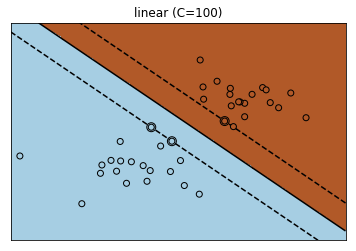

In [4]:
plot_svm()

図中の二重丸はSupport vectorを表します．

## 3.3 ソフトマージン線形SVM
### 3.3.1 主問題

ハードマージン線形SVMでは，訓練データは全て線形分離可能と仮定していましたが，実際にはそうとは限りません．そこで，誤分類のペナルティ変数$\xi_n = \mid y_n - \hat{y}(\mathbf{x}_n) \mid$を導入し，線形SVMを拡張します．

<img src="fig/soft_svm.png" width="360px">

上図に示す通り，正しく分類されたデータに対しては$\xi=0$，決定境界$\hat{y}(\mathbf{x})=0$上のデータについては$\xi=1$，そして誤分類されたデータに対しては$\xi > 1$が成り立ちます．
(6)(7)式にペナルティ変数$\xi_n$を導入すると，以下の最適化問題を得ます．

* minimize: $C \sum_{n=1}^N \xi_n + \dfrac{1}{2} \mid \mid \mathbf{w} \mid \mid^2$ ...(20)
* subject to:
  * $y_n \left(\mathbf{w}^T \mathbf{x}_n + b \right) \geq 1 - \xi_n$，$n=1, \dots, N$ ...(21)
  * $\xi_n \geq 0$，$n=1, \dots, N$  ...(22)
  
ここで，$C > 0$はペナルティ項とマージンの大きさを制御するパラメータです．なお，$C \to \infty$の極限において，ハードマージン線形SVMの最適化問題と等しくなります． 

### 3.3.2 双対問題
3.2.2節と同様の手順で双対問題を導出すると：
* maximize: $\tilde{L}(\mathbf{a}) = \sum_{n=1}^N a_n - \dfrac{1}{2}\sum_{n=1}^N\sum_{m=1}^N a_n a_m y_n y_m \mathbf{x}_n^T \mathbf{x}_m$ ...(23)
* subject to:
  * $0 \leq a_n \leq C$，$n=1, \dots, N$ ...(24)
  * $\sum_{n=1}^N a_n y_n = 0$ ...(25)

### 3.3.3 決定境界
3.2.3節と同様にKKT条件を考慮すると，(18)および(19)式で$\mathbf{w}$および$b$を計算できます．

### 3.3.4 デモ
3.2.4節で定義した`plot_svm()`の引数`C`に小さな値を与えることで，ソフトマージン線形SVMの振る舞いを確認します．

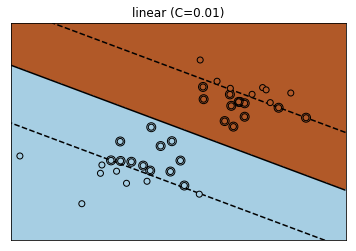

In [5]:
plot_svm(C=0.01)

ハードマージン線形SVMと比較し，Support vectorの数が増え，またマージンが大きくなっていることが確認できます．

## 3.4 非線形SVM

### 3.4.1 主問題

線形SVMでは，直線的な決定境界しか扱えないため，下図のような複雑な構造を持つデータ$\mathbf{x}$をうまく分類できませんでした．
そこで，何らかの非線形変換$\mathbf{\phi}(\mathbf{x})$により，線形分離可能な空間に写像することを考えます．
ここで，写像先の空間を**特徴空間**と呼びます．
特徴空間の次元は，写像前の次元と同じである必要はありません．

<img src="fig/phi.png" width="480px">

つまり，下式でラベル$y_n \in \{-1, 1\}$を予測する問題を考えます．

$\hat{y}(\mathbf{x}_n) = \mathbf{w}^T \mathbf{\phi}(\mathbf{x}_n) + b$ ...(26)

3.3.1節の(20)(21)(22)式の$\mathbf{x}_n$を$\mathbf{\phi}(\mathbf{x}_n)$に置き換えると，非線形SVMの主問題を導出できます．
なお，特に断らない限り，以降ではソフトマージンを想定します．

* minimize: $C \sum_{n=1}^N \xi_n + \dfrac{1}{2} \mid \mid \mathbf{w} \mid \mid^2$ ...(27)
* subject to:
  * $y_n \left(\mathbf{w}^T \mathbf{\phi}(\mathbf{x}_n) + b \right) \geq 1 - \xi_n$，$n=1, \dots, N$ ...(28)
  * $\xi_n \geq 0$，$n=1, \dots, N$  ...(29)

### 3.4.2 双対問題
3.3.2節の(23)(24)(25)式の$\mathbf{x}_n$を$\mathbf{\phi}(\mathbf{x}_n)$に置き換えると，非線形SVMの双対問題を導出できます．

* maximize: $\tilde{L}(\mathbf{a}) = \sum_{n=1}^N a_n - \dfrac{1}{2}\sum_{n=1}^N\sum_{m=1}^N a_n a_m y_n y_m k(\mathbf{x}_n, \mathbf{x}_m)$ ...(30)
* subject to:
  * $0 \leq a_n \leq C$，$n=1, \dots, N$ ...(31)
  * $\sum_{n=1}^N a_n y_n = 0$ ...(32)
  
ここで，$k(\mathbf{x}_n, \mathbf{x}_m) = \mathbf{\phi}(\mathbf{x}_n)^T \mathbf{\phi}(\mathbf{x}_m)$を**カーネル**（kernel）と呼びます．

### 3.4.3 決定境界
3.2.3節の(18)(19)式の$\mathbf{x}_n$を$\mathbf{\phi}(\mathbf{x}_n)$に置き換え，かつ(26)式に代入すると，非線形SVMの予測関数$\hat{y}(\mathbf{x})$を導出できます．

$\hat{y}(\mathbf{x}) = \sum_{n \in N_S} a_n y_n k(\mathbf{x}, \mathbf{x}_n) + \dfrac{1}{\mid N_S \mid} \sum_{n\in N_S} \left(y_n - \sum_{m\in N_S}a_m y_m k(\mathbf{x}_n, \mathbf{x}_m )\right)$  ...(33)

### 3.4.4 カーネルトリック
非線形SVMでは，訓練データの学習時に最適化問題(30)-(32)を，テストデータの予測時に式(33)を計算します．
ここで重要なのは，いずれの式においても写像$\mathbf{\phi}(\mathbf{x})$は直接登場せず，その内積であるカーネル$k(\mathbf{x}, \mathbf{x}')$のみが登場する，ということです．このように，写像$\mathbf{\phi}(\mathbf{x})$を直接的に扱わず，カーネル$k(\mathbf{x}, \mathbf{x}')$を通して間接的に扱う手法を**カーネルトリック**と呼びます．カーネルトリックは，主成分分析や最近傍分類器等にも応用することができます．

最もよく使われるカーネルは，ラジアル基底関数（RBF; radial basis function）カーネルです．

$k(\mathbf{x}, \mathbf{x}')=\mathrm{exp}\left(-\dfrac{\mid\mid \mathbf{x} - \mathbf{x}'\mid\mid^2}{2 \sigma ^2}\right) $

なお，RBFカーネルの写像$\mathbf{\phi}(\mathbf{x})$は無限次元のため，直接取り扱うことはできません．RBFカーネルの他にも，様々なカーネルが存在します．詳細は[C. M. ビショップ，パターン認識と機械学習](http://amzn.asia/0OTDQtT)をご参照ください．

### 3.4.5 デモ
3.2.4節で定義した`plot_svm()`の引数に`rbf`を与えることで，非線形SVMの振る舞いを確認します．

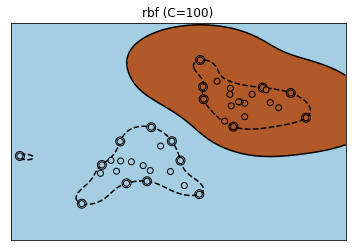

In [6]:
plot_svm(kernel='rbf')

決定境界がこれまでと明らかに異なることが確認できます．